Stacked-Sandwich Bottleneck (SSB) Architecture for Efficient Feature Extraction and Classification

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

file_path = "DATASET-1.csv"
df = pd.read_csv(file_path)

numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(exclude=['number']).columns

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
y = y - 1

selector = SelectKBest(score_func=f_classif, k=961)
X_selected = selector.fit_transform(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

X_reshaped = X_scaled.reshape(-1, 31, 31, 1)
X_padded = np.pad(X_reshaped, ((0, 0), (0, 1), (0, 1), (0, 0)), mode='constant')
X_rgb = np.repeat(X_padded, 3, axis=-1)

num_classes = len(np.unique(y))
y_categorical = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_rgb, y_categorical, test_size=0.2, random_state=42)

input_layer = Input(shape=(32, 32, 3))

vgg16_1 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3), name='v1')
vgg16_1.trainable = False
x = vgg16_1(input_layer)

x = Conv2D(3, (1, 1), padding='same')(x)
x = UpSampling2D(size=(32, 32))(x)

vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3), name='v2')
vgg19.trainable = False
x = vgg19(x)

x = Conv2D(3, (1, 1), padding='same')(x)
x = UpSampling2D(size=(32, 32))(x)

vgg16_2 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3), name='v3')
vgg16_2.trainable = False
x = vgg16_2(x)

x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=22, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Epoch 1/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.2535 - loss: 2.0167 - val_accuracy: 0.4761 - val_loss: 1.4461
Epoch 2/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4611 - loss: 1.5583 - val_accuracy: 0.2321 - val_loss: 1.6215
Epoch 3/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5279 - loss: 1.4015 - val_accuracy: 0.2392 - val_loss: 1.5521
Epoch 4/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5274 - loss: 1.3428 - val_accuracy: 0.3301 - val_loss: 1.4655
Epoch 5/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5721 - loss: 1.2716 - val_accuracy: 0.4545 - val_loss: 1.3329
Epoch 6/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6199 - loss: 1.1284 - val_accuracy: 0.4115 - val_loss: 1.4795
Epoch 7/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5833 - loss: 1.1945 - val_accuracy: 0.2895 - val_loss: 1.6639
Epoch 8/22
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6518 - loss: 1.0801 - val_accuracy: 0.5335 -

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import numpy as np

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
mse = mean_squared_error(y_true, y_pred)


print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MSE:       {mse:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Accuracy:  0.5311
Precision: 0.4324
Recall:    0.3397
F1 Score:  0.2703
MSE:       3.8397


 Classification Using VGG16 Architecture

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error

file_path = "DATASET-1.csv"
df = pd.read_csv(file_path)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

if y.dtype == 'object':
    y = pd.factorize(y)[0]

selector = SelectKBest(score_func=f_classif, k=961)
X_selected = selector.fit_transform(X, y)

X_reshaped = X_selected.reshape(-1, 31, 31, 1)
X_padded = np.pad(X_reshaped, ((0, 0), (0, 1), (0, 1), (0, 0)), mode='constant')

num_classes = len(np.unique(y))
y_categorical = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

input_layer = Input(shape=(32, 32, 1), name="input_layer")
vgg16 = VGG16(weights=None, include_top=False, input_shape=(32, 32, 1), name="vgg16")
vgg16_features = vgg16(input_layer)

flatten = Flatten(name="flatten")(vgg16_features)
dense = Dense(512, activation='relu', name="dense")(flatten)
output_layer = Dense(num_classes, activation='softmax', name="output_layer")(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")


Shape after feature selection: (2086, 961)
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.3426 - loss: 5.4887 - val_accuracy: 0.4402 - val_loss: 1.3188
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5206 - loss: 1.1444 - val_accuracy: 0.5909 - val_loss: 1.0404
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6500 - loss: 0.9506 - val_accuracy: 0.5885 - val_loss: 1.4932
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6771 - loss: 0.7745 - val_accuracy: 0.7990 - val_loss: 0.5132
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7884 - loss: 0.5604 - val_accuracy: 0.8062 - val_loss: 0.6966
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7759 - loss: 0.6493 - val_accuracy: 0.7512 - val_loss: 0.5757
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8101 - loss: 0.4708 - val_accuracy: 0.8684 - val_loss: 0.3445
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8

Classification Using VGG19 Architecture

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error

file_path = "DATASET-1.csv"
df = pd.read_csv(file_path)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

if y.dtype == 'object':
    y = pd.factorize(y)[0]

selector = SelectKBest(score_func=f_classif, k=961)
X_selected = selector.fit_transform(X, y)

X_reshaped = X_selected.reshape(-1, 31, 31, 1)
X_padded = np.pad(X_reshaped, ((0, 0), (0, 1), (0, 1), (0, 0)), mode='constant')

num_classes = len(np.unique(y))
y_categorical = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

input_layer = Input(shape=(32, 32, 1), name="input_layer")
vgg19 = VGG19(weights=None, include_top=False, input_shape=(32, 32, 1), name="vgg19")
vgg19_features = vgg19(input_layer)

flatten = Flatten(name="flatten")(vgg19_features)
dense = Dense(512, activation='relu', name="dense")(flatten)
output_layer = Dense(num_classes, activation='softmax', name="output_layer")(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")


Shape after feature selection: (2086, 961)
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.3519 - loss: 11.7187 - val_accuracy: 0.4402 - val_loss: 1.4417
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.4226 - loss: 1.4124 - val_accuracy: 0.5239 - val_loss: 1.3497
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5232 - loss: 1.1844 - val_accuracy: 0.5981 - val_loss: 1.0701
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.6318 - loss: 0.9769 - val_accuracy: 0.6292 - val_loss: 0.8900
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6742 - loss: 0.7771 - val_accuracy: 0.5933 - val_loss: 1.2920
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5490 - loss: 1.1761 - val_accuracy: 0.6579 - val_loss: 0.9789
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7278 - loss: 0.6726 - val_accuracy: 0.7584 - val_loss: 0.6581
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.

Classification Using INCEPTION V3 Architecture

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error

file_path = "DATASET-1.csv"
df = pd.read_csv(file_path)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

if y.dtype == 'object':
    y = pd.factorize(y)[0]

selector = SelectKBest(score_func=f_classif, k=961)
X_selected = selector.fit_transform(X, y)

X_reshaped = X_selected.reshape(-1, 31, 31, 1)
X_padded = np.pad(X_reshaped, ((0, 0), (22, 22), (22, 22), (0, 0)), mode='constant')

num_classes = len(np.unique(y))
y_categorical = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

input_layer = Input(shape=(75, 75, 1), name="input_layer")
inception = InceptionV3(weights=None, include_top=False, input_shape=(75, 75, 1), name="inception_v3")
inception_features = inception(input_layer)

flatten = Flatten(name="flatten")(inception_features)
dense = Dense(512, activation='relu', name="dense")(flatten)
output_layer = Dense(num_classes, activation='softmax', name="output_layer")(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")


Shape after feature selection: (2086, 961)
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 108s 758ms/step - accuracy: 0.4758 - loss: 1.6849 - val_accuracy: 0.4474 - val_loss: 3.5529
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.7072 - loss: 0.9294 - val_accuracy: 0.4474 - val_loss: 1.5817
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6940 - loss: 0.8336 - val_accuracy: 0.4450 - val_loss: 1.8167
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5744 - loss: 1.2995 - val_accuracy: 0.4569 - val_loss: 2.3214
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7342 - loss: 0.7386 - val_accuracy: 0.6651 - val_loss: 1.1883
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7403 - loss: 0.6698 - val_accuracy: 0.6555 - val_loss: 1.1622
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7836 - loss: 0.5686 - val_accuracy: 0.7344 - val_loss: 0.9479
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0

Classification Using ResNet50 Architecture

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error

file_path = "PRO_DATASET-1.csv"
df = pd.read_csv(file_path)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

if y.dtype == 'object':
    y = pd.factorize(y)[0]

selector = SelectKBest(score_func=f_classif, k=961)
X_selected = selector.fit_transform(X, y)

X_reshaped = X_selected.reshape(-1, 31, 31, 1)
X_padded = np.pad(X_reshaped, ((0, 0), (16, 17), (16, 17), (0, 0)), mode='constant')

num_classes = len(np.unique(y))
y_categorical = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

input_layer = Input(shape=(64, 64, 1), name="input_layer")
resnet = ResNet50(weights=None, include_top=False, input_shape=(64, 64, 1), name="resnet50")
resnet_features = resnet(input_layer)

flatten = Flatten(name="flatten")(resnet_features)
dense = Dense(512, activation='relu', name="dense")(flatten)
output_layer = Dense(num_classes, activation='softmax', name="output_layer")(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")


Shape after feature selection: (2086, 961)
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 479ms/step - accuracy: 0.3391 - loss: 10.9919 - val_accuracy: 0.1196 - val_loss: 8.4167
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.4323 - loss: 2.4073 - val_accuracy: 0.3947 - val_loss: 6.0569
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5851 - loss: 1.1515 - val_accuracy: 0.5287 - val_loss: 1.2281
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6900 - loss: 0.7714 - val_accuracy: 0.6531 - val_loss: 0.9147
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.6939 - loss: 0.7859 - val_accuracy: 0.7416 - val_loss: 0.6739
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8270 - loss: 0.4530 - val_accuracy: 0.7440 - val_loss: 0.6241
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8429 - loss: 0.4135 - val_accuracy: 0.8708 - val_loss: 0.4201
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.

Comparison of Model Accuracies

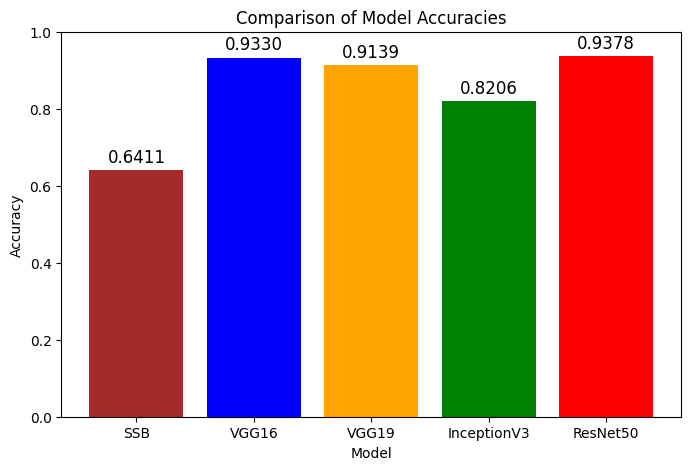

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


models = ['SSB', 'VGG16', 'VGG19', 'InceptionV3', 'ResNet50']
accuracies = [0.6411, 0.9330, 0.9139, 0.8206, 0.9378]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['brown', 'blue', 'orange', 'green', 'red'])


plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")


plt.yticks(np.arange(0, 1.1, 0.2))


for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', fontsize=12)


plt.show()

Comparison of MSE Across Different Models

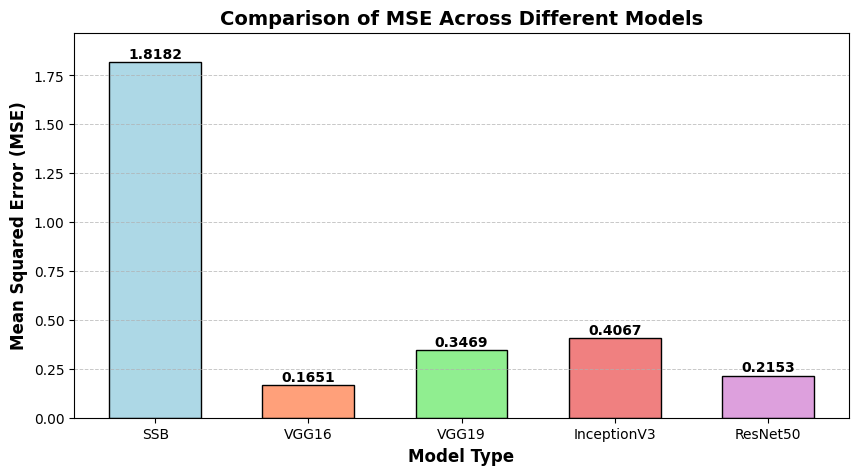

In [ ]:
import matplotlib.pyplot as plt

models = ["SSB", "VGG16", "VGG19", "InceptionV3", "ResNet50"]
mse_values = [1.8182, 0.1651, 0.3469, 0.4067, 0.2153]
colors = ['lightblue', 'lightsalmon', 'lightgreen', 'lightcoral', 'plum']

plt.figure(figsize=(10, 5))
plt.bar(models, mse_values, color=colors, width=0.6, edgecolor='black')

plt.xlabel("Model Type", fontsize=12, fontweight='bold')
plt.ylabel("Mean Squared Error (MSE)", fontsize=12, fontweight='bold')
plt.title("Comparison of MSE Across Different Models", fontsize=14, fontweight='bold')

plt.ylim(0, max(mse_values) + 0.15)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

for i, v in enumerate(mse_values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=10, fontweight='bold')

plt.show()


Classification using RNN-CNN Classifier






In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import SimpleRNN, LSTM, Reshape, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

dataset_path = 'DATASET-1.csv'
df = pd.read_csv(dataset_path)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=961)
X_selected = selector.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

X_train = X_train.reshape(-1, 31, 31, 1)
X_test = X_test.reshape(-1, 31, 31, 1)

X_train = np.pad(X_train, ((0, 0), (0, 1), (0, 1), (0, 0)), mode='constant')
X_test = np.pad(X_test, ((0, 0), (0, 1), (0, 1), (0, 0)), mode='constant')

model = Sequential()
model.add(Conv2D(32, (2, 2), strides=(2, 2), activation='relu', padding='same', input_shape=(32, 32, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (2, 2), strides=(2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (2, 2), strides=(2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Reshape((4, 512)))
model.add(SimpleRNN(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
mse = mean_squared_error(y_true_classes, y_pred_classes)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")


First few rows:
       'AARS'   'ABCB6'    'ABCC5'    'ABCF1'    'ABCF3'    'ABHD4'   'ABHD6'  \
0  44.023542  9.216286  11.319078  33.215176  16.901427   9.031338  1.109961   
1  29.746157  9.765600  40.540128  30.169134  20.047393  32.237287  2.460624   
2  35.799315  9.884781   3.886043  29.984211  17.135946  21.273727  1.501203   
3  26.490401  7.085828  10.804003  23.482255  17.044085  14.880104  1.299056   
4  27.632466  7.642971   3.670265  16.584843  20.375321  22.174600  1.553541   

      'ABL1'    'ACAA1'    'ACAT2'  ...    'ZMYM2'   'ZNF131'  'ZNF274'  \
0  20.017821  16.724363  10.494192  ...  21.706486  16.315579  4.224009   
1  17.029112  28.346167  17.017284  ...  12.815215  10.150965  8.914809   
2  20.598204  25.855152  12.275738  ...  14.344729  11.224647  7.870991   
3  14.978582  31.214294  10.015235  ...  13.660995   9.730124  7.804760   
4  14.909150  54.435490  13.392213  ...  16.650019   8.584938  7.485410   

   'ZNF318'   'ZNF395'   'ZNF451'  'ZNF586'  'ZNF58

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_684 (Conv2D)                  │ (None, 16, 16, 32)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_666              │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_685 (Conv2D)                  │ (None, 8, 8, 64)            │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_667              │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_686 (Conv2D)                  │ (None, 4, 4, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_668              │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 4, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 4, 128)              │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 4, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,405 (1009.39 KB)

 Trainable params: 257,957 (1007.64 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7334 - loss: 0.7667 - val_accuracy: 0.3421 - val_loss: 1.6736
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9688 - loss: 0.0819 - val_accuracy: 0.1196 - val_loss: 3.1091
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9857 - loss: 0.0414 - val_accuracy: 0.1196 - val_loss: 3.2139
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9928 - loss: 0.0232 - val_accuracy: 0.1196 - val_loss: 3.7662
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9897 - loss: 0.0300 - val_accuracy: 0.1196 - val_loss: 3.1087
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9951 - loss: 0.0183 - val_accuracy: 0.4641 - val_loss: 1.3529
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9958 - loss: 0.0149 - val_accuracy: 0.5574 - val_loss: 1.4120
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9936 - loss: 0.0178 - val_accuracy: 0.8373 - v

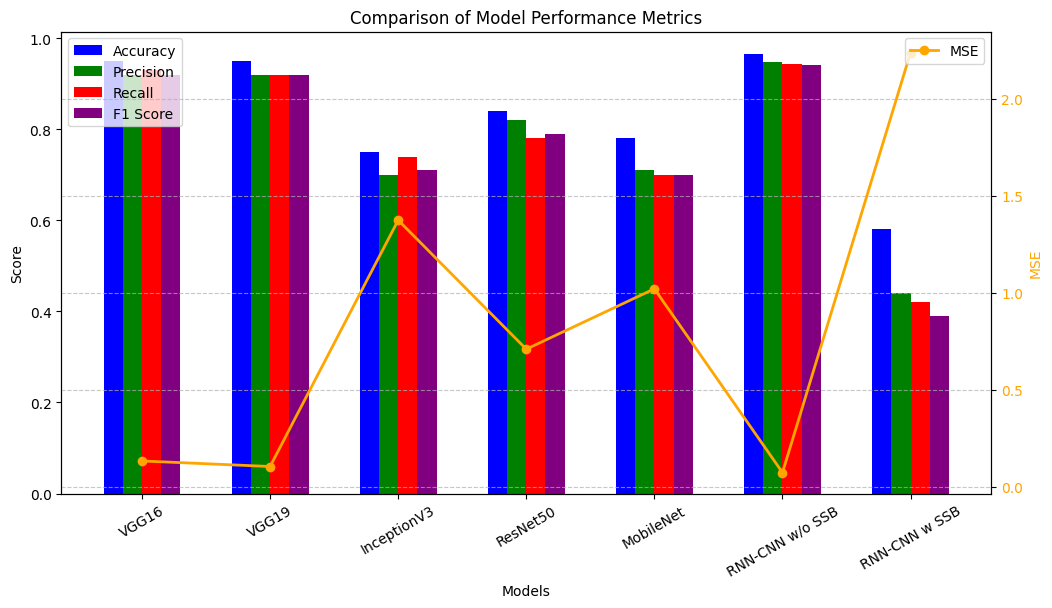

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ["VGG16", "VGG19", "InceptionV3", "ResNet50", "MobileNet", "RNN-CNN w/o SSB", "RNN-CNN w SSB"]

accuracy = [0.95, 0.95, 0.75, 0.84, 0.78, 0.9665, 0.58]
precision = [0.92, 0.92, 0.70, 0.82, 0.71, 0.9472, 0.44]
recall = [0.93, 0.92, 0.74, 0.78, 0.70, 0.9441, 0.42]
f1_score = [0.92, 0.92, 0.71, 0.79, 0.70, 0.9423, 0.39]
mse = [0.1339, 0.1053, 1.3756, 0.7105, 1.0215, 0.0742, 2.24]


bar_width = 0.15
x = np.arange(len(models))

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(x - 1.5 * bar_width, accuracy, bar_width, label="Accuracy", color="b")
ax1.bar(x - 0.5 * bar_width, precision, bar_width, label="Precision", color="g")
ax1.bar(x + 0.5 * bar_width, recall, bar_width, label="Recall", color="r")
ax1.bar(x + 1.5 * bar_width, f1_score, bar_width, label="F1 Score", color="purple")

ax2 = ax1.twinx()
ax2.plot(x, mse, marker="o", linestyle="-", color="orange", label="MSE", linewidth=2)
ax2.set_ylabel("MSE", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")


ax1.set_xlabel("Models")
ax1.set_ylabel("Score")
ax1.set_title("Comparison of Model Performance Metrics")
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=30)


ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
